In [160]:
# These are probably more imports than we need. Copied from comparison tool
import pandas as pd
import os
import sys

# TODO: add to poetry
import shapely
import warnings
from pandarallel import pandarallel

pandarallel.initialize(progress_bar=True, 
                       # If nb_workers is not set, it defaults to available cores.
                       nb_workers=8)

from tqdm.notebook import tqdm_notebook

module_path = os.path.abspath(os.path.join("../.."))
if module_path not in sys.path:
    sys.path.append(module_path)

# from data_pipeline.utils import remove_all_from_dir, get_excel_column_name
# from data_pipeline.etl.base import ExtractTransformLoad
# from data_pipeline.etl.sources.census.etl_utils import get_state_information
# from data_pipeline.etl.sources.ejscreen_areas_of_concern.etl import (
#     EJSCREENAreasOfConcernETL,
# )

from data_pipeline.etl.sources.census.etl import CensusETL


# from data_pipeline.score import field_names

# %load_ext lab_black
# Turn on TQDM for pandas so that we can have progress bars when running `apply`.
tqdm_notebook.pandas()

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [136]:
# Define some input fields
LAT_FIELD = "Latitude"
LONG_FIELD = "Longitude"
KEY_FIELD = "AMLIS Key"


# TODO: switch to whole US
# GEOJSON_PATH = CensusETL().GEOJSON_PATH / "us.json"
GEOJSON_PATH = CensusETL().GEOJSON_PATH / "02.json"
GEOJSON_TRACT_ID_FIELD = "GEOID10"

2022-07-11 17:59:18,012 [data_pipeline.etl.sources.census.etl_utils] INFO     Downloading fips from S3 repository
2022-07-11 17:59:18,020 [data_pipeline.utils] INFO     Downloading https://justice40-data.s3.amazonaws.com/data-sources/fips_states_2010.zip
2022-07-11 17:59:18,504 [data_pipeline.utils] INFO     Extracting /Users/lucas/Documents/usds/repos/justice40-tool/data/data-pipeline/data_pipeline/data/tmp/downloaded-a16d79e8-76b5-4cc9-8ba8-edead13aaaaf.zip


In [137]:
# Load geojson
import geopandas

census_tract_gdf = geopandas.read_file(GEOJSON_PATH)

print(census_tract_gdf)

    STATEFP10 COUNTYFP10 TRACTCE10      GEOID10 NAME10          NAMELSAD10  \
0          02        013    000100  02013000100      1      Census Tract 1   
1          02        016    000200  02016000200      2      Census Tract 2   
2          02        016    000100  02016000100      1      Census Tract 1   
3          02        240    000100  02240000100      1      Census Tract 1   
4          02        240    000400  02240000400      4      Census Tract 4   
..        ...        ...       ...          ...    ...                 ...   
162        02        020    002813  02020002813  28.13  Census Tract 28.13   
163        02        020    002821  02020002821  28.21  Census Tract 28.21   
164        02        020    002822  02020002822  28.22  Census Tract 28.22   
165        02        020    002823  02020002823  28.23  Census Tract 28.23   
166        02        020    002900  02020002900     29     Census Tract 29   

    MTFCC10 FUNCSTAT10      ALAND10     AWATER10   INTPTLAT10  

In [138]:
eamlis_path = "/Users/lucas/Downloads/eAMLIS export of all data.tsv"
eamlis_source_df = pd.read_csv(
    filepath_or_buffer=eamlis_path,
    sep="\t",
)

eamlis_source_df.head()

/var/folders/lx/xmq8p65j71v9xq2bhsd2j5w40000gp/T/ipykernel_13151/509584448.py:2: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  eamlis_source_df = pd.read_csv(


,AMLIS Key,State/Tribe,County,Congressional District,Quadrangle Name,Watershed,HUC Code,FIPS Code,Latitude,Longitude,...,Unfunded Metric Units,Funded Standard Units,Funded Costs,Funded GPRA Acres,Funded Metric Units,Completed Standard Units,Completed Costs,Completed GPRA Acres,Completed Metric Units,Unnamed: 40
0,AK000001,AK,MATANUSKA-SUSITNA,1.0,ANCHORAGE C-8,NaN,NaN,02170,61.6,-149.8,...,0.0,0.0,0.0,0.0,0.0,2.0,10000.0,0.20,2.0,NaN
1,AK000001,AK,MATANUSKA-SUSITNA,1.0,ANCHORAGE C-8,NaN,NaN,02170,61.6,-149.8,...,0.0,0.0,0.0,0.0,0.0,4.0,20000.0,0.40,4.0,NaN
2,AK000001,AK,MATANUSKA-SUSITNA,1.0,ANCHORAGE C-8,NaN,NaN,02170,61.6,-149.8,...,0.0,0.0,0.0,0.0,0.0,900.0,33200.0,12.86,274.3,NaN
3,AK000002,AK,FAIRBANKS NORTH STAR,1.0,Fairbanks D-3,19030004,NaN,02090,64.8,-148.0,...,0.0,0.0,0.0,0.0,0.0,8.0,35324.0,0.80,8.0,NaN
4,AK000002,AK,FAIRBANKS NORTH STAR,1.0,Fairbanks D-3,19030004,NaN,02090,64.8,-148.0,...,0.0,0.0,0.0,0.0,0.0,1.0,4416.0,0.10,1.0,NaN


In [139]:
mines_df = eamlis_source_df

print(mines_df.columns)

# TODO: investigate how to combine multiple rows for the same lat/long.
# This just keeps one of the rows arbitrarily. We might need additional columns of information.
mines_unique_df = mines_df.drop_duplicates(subset=[LAT_FIELD, LONG_FIELD], keep="last")

# TODO: investigate whether other columns (such as mine problem severity) are needed.
mines_unique_df = mines_unique_df[[KEY_FIELD, LAT_FIELD, LONG_FIELD]]

mines_unique_df = mines_unique_df.head(100)
mines_unique_df.head()

Index(['AMLIS Key', 'State/Tribe', 'County', 'Congressional District',
       'Quadrangle Name', 'Watershed', 'HUC Code', 'FIPS Code', 'Latitude',
       'Longitude', 'Funding Source / Program', 'Problem Area Name',
       'Problem Area Number', 'Planning Unit Name', 'Planning Unit Number',
       'Problem Priority', 'Problem Type', 'Mining Type', 'Ore Types',
       'Date Prepared', 'Date Revised', 'Private Owner %', 'State Owner %',
       'Other Federal Owner %', 'Park Service Owner %',
       'Forest Service Owner %', 'Indian Owner %', 'BLM Owner %',
       'Unfunded Standard Units', 'Unfunded Costs', 'Unfunded GPRA Acres',
       'Unfunded Metric Units', 'Funded Standard Units', 'Funded Costs',
       'Funded GPRA Acres', 'Funded Metric Units', 'Completed Standard Units',
       'Completed Costs', 'Completed GPRA Acres', 'Completed Metric Units',
       'Unnamed: 40'],
      dtype='object')


,AMLIS Key,Latitude,Longitude
2,AK000001,61.6,-149.8
6,AK000003,61.6,-144.0
12,AK000006,61.7,-149.0
25,AK000012,61.6,-148.9
30,AK000015,61.7,-148.2


In [140]:
mines_unique_df

mines_gdf = geopandas.GeoDataFrame(
    mines_unique_df,
    geometry=geopandas.points_from_xy(
        x=mines_unique_df[LONG_FIELD], y=mines_unique_df[LAT_FIELD]
    ),
)

mines_gdf

/Users/lucas/.virtualenvs/scoring2/lib/python3.9/site-packages/geopandas/array.py:275: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  return GeometryArray(vectorized.points_from_xy(x, y, z), crs=crs)


,AMLIS Key,Latitude,Longitude,geometry
2,AK000001,61.6,-149.8,POINT (-149.80000 61.60000)
6,AK000003,61.6,-144.0,POINT (-144.00000 61.60000)
12,AK000006,61.7,-149.0,POINT (-149.00000 61.70000)
25,AK000012,61.6,-148.9,POINT (-148.90000 61.60000)
30,AK000015,61.7,-148.2,POINT (-148.20000 61.70000)
...,...,...,...,...
2501,AL000709,34.4,-85.6,POINT (-85.60000 34.40000)
2510,AL000711,33.2,-87.2,POINT (-87.20000 33.20000)
2515,AL000714,34.5,-85.7,POINT (-85.70000 34.50000)
2524,AL000718,33.3,-87.3,POINT (-87.30000 33.30000)


<AxesSubplot:>

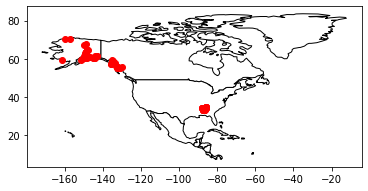

In [141]:
# Can be deleted from production code
# Printing for inspection
# We restrict to South America.
world = geopandas.read_file(geopandas.datasets.get_path("naturalearth_lowres"))

ax = world[world.continent == "North America"].plot(color="white", edgecolor="black")

# We can now plot our ``GeoDataFrame``.
mines_gdf.plot(ax=ax, color="red")

In [153]:
# long = -149.8
# lat = 61.6

# METHOD DEFINITIONS


def get_census_tract_for_one_coordinate(
    geom_point: shapely.geometry.point.Point,
    census_tract_gdf: geopandas.geodataframe.GeoDataFrame,
) -> str:
    # GEOJSON_TRACT_ID_FIELD

    # geopandas' contain method works row to row.
    # So create a duplicate row for the point across the length of the census tract gdf
    #     number_of_census_tracts = len(census_tract_gdf)
    #     point_as_gdf = geopandas.GeoDataFrame([[geom_point] * number_of_census_tracts])

    # Now run a row-to-row contains
    #     print(point_as_gdf)

    contains_result = census_tract_gdf.contains(geom_point)
    count_of_census_tract_matches = len(census_tract_gdf[contains_result])

    if count_of_census_tract_matches == 0:
        warnings.warn(
            f"Warning: no tract matches for {geom_point}",
            DeprecationWarning,
            stacklevel=2,
        )
        census_tract_id = None

    elif count_of_census_tract_matches > 1:
        warnings.warn(
            f"Warning: too many tract matches for {geom_point}",
            DeprecationWarning,
            stacklevel=2,
        )
        census_tract_id = None

    else:
        # With only one tract returned, extract the ID.
        census_tract_id = census_tract_gdf[contains_result][
            GEOJSON_TRACT_ID_FIELD
        ].values[0]

    return census_tract_id


def get_census_tracts_for_geom_points(
    points_gdf: geopandas.geodataframe.GeoDataFrame,
    census_tract_gdf: geopandas.geodataframe.GeoDataFrame,
) -> geopandas.geodataframe.GeoDataFrame:
    geometry_column_name = "geometry"
    result_gdf = points_gdf.parallel_apply(
        lambda frame: get_census_tract_for_one_coordinate(
            geom_point=frame[geometry_column_name], census_tract_gdf=census_tract_gdf
        ),
        axis=1,
    )
    return result_gdf


# get_census_tract_for_one_coordinate(geom_point=)

# example_point = geopandas.points_from_xy(x=[long], y=[lat])[0]

# get_census_tract_for_one_coordinate(
#     geom_point=example_point, census_tract_gdf=census_tract_gdf
# )

In [161]:
def get_census_tracts_for_dataframe_with_lat_long(
    coordinate_df: pd.DataFrame,
    latitude_column: str = LAT_FIELD,
    longitude_column: str = LONG_FIELD,
    census_tract_gdf: geopandas.geodataframe.GeoDataFrame = census_tract_gdf,
):
    # First, convert the plain DataFrame into a geopandas data frame with lat/long geometry points.
    coordinate_geopandas_gdf = geopandas.GeoDataFrame(
        coordinate_df,
        geometry=geopandas.points_from_xy(
            x=coordinate_df[longitude_column], y=coordinate_df[latitude_column]
        ),
    )

    # Find the tract IDs for each point. 
    tract_results = get_census_tracts_for_geom_points(
        points_gdf=coordinate_geopandas_gdf, census_tract_gdf=census_tract_gdf
    )

    # Join the tract IDs back on the original dataframe 
    # Join using the index 
    print(coordinate_df)
    
    return tract_results


x = get_census_tracts_for_dataframe_with_lat_long(coordinate_df=mines_unique_df)

print(x)
# print(coordinate_df)

/Users/lucas/.virtualenvs/scoring2/lib/python3.9/site-packages/geopandas/array.py:275: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  return GeometryArray(vectorized.points_from_xy(x, y, z), crs=crs)


/var/folders/lx/xmq8p65j71v9xq2bhsd2j5w40000gp/T/ipykernel_13151/544546657.py:51: DeprecationWarning: Warning: no tract matches for POINT (-130 55.9)
  lambda frame: get_census_tract_for_one_coordinate(
/var/folders/lx/xmq8p65j71v9xq2bhsd2j5w40000gp/T/ipykernel_13151/544546657.py:51: DeprecationWarning: Warning: no tract matches for POINT (-86.6 33.9)
  lambda frame: get_census_tract_for_one_coordinate(
/var/folders/lx/xmq8p65j71v9xq2bhsd2j5w40000gp/T/ipykernel_13151/544546657.py:51: DeprecationWarning: Warning: no tract matches for POINT (-86.1 33.7)
  lambda frame: get_census_tract_for_one_coordinate(
/var/folders/lx/xmq8p65j71v9xq2bhsd2j5w40000gp/T/ipykernel_13151/544546657.py:51: DeprecationWarning: Warning: no tract matches for POINT (-87.1 33.1)
  lambda frame: get_census_tract_for_one_coordinate(
/var/folders/lx/xmq8p65j71v9xq2bhsd2j5w40000gp/T/ipykernel_13151/544546657.py:51: DeprecationWarning: Warning: no tract matches for POINT (-85.6 34.5)
  lambda frame: get_census_tract_f

/var/folders/lx/xmq8p65j71v9xq2bhsd2j5w40000gp/T/ipykernel_13151/544546657.py:51: DeprecationWarning: Warning: no tract matches for POINT (-85.7 34.5)
  lambda frame: get_census_tract_for_one_coordinate(
/var/folders/lx/xmq8p65j71v9xq2bhsd2j5w40000gp/T/ipykernel_13151/544546657.py:51: DeprecationWarning: Warning: no tract matches for POINT (-86.6 33.3)
  lambda frame: get_census_tract_for_one_coordinate(
/var/folders/lx/xmq8p65j71v9xq2bhsd2j5w40000gp/T/ipykernel_13151/544546657.py:51: DeprecationWarning: Warning: no tract matches for POINT (-87.6 33.9)
  lambda frame: get_census_tract_for_one_coordinate(
/var/folders/lx/xmq8p65j71v9xq2bhsd2j5w40000gp/T/ipykernel_13151/544546657.py:51: DeprecationWarning: Warning: no tract matches for POINT (-87.4 33.5)
  lambda frame: get_census_tract_for_one_coordinate(
/var/folders/lx/xmq8p65j71v9xq2bhsd2j5w40000gp/T/ipykernel_13151/544546657.py:51: DeprecationWarning: Warning: no tract matches for POINT (-87.3 33.5)
  lambda frame: get_census_tract_

     AMLIS Key  Latitude  Longitude                     geometry
2     AK000001      61.6     -149.8  POINT (-149.80000 61.60000)
6     AK000003      61.6     -144.0  POINT (-144.00000 61.60000)
12    AK000006      61.7     -149.0  POINT (-149.00000 61.70000)
25    AK000012      61.6     -148.9  POINT (-148.90000 61.60000)
30    AK000015      61.7     -148.2  POINT (-148.20000 61.70000)
...        ...       ...        ...                          ...
2501  AL000709      34.4      -85.6   POINT (-85.60000 34.40000)
2510  AL000711      33.2      -87.2   POINT (-87.20000 33.20000)
2515  AL000714      34.5      -85.7   POINT (-85.70000 34.50000)
2524  AL000718      33.3      -87.3   POINT (-87.30000 33.30000)
2544  AL000726      33.0      -87.1   POINT (-87.10000 33.00000)

[100 rows x 4 columns]
2       02170000401
6       02261000100
12      02170000200
25      02170001300
30      02170000200
           ...     
2501           None
2510           None
2515           None
2524           N

In [154]:
result_gdf = get_census_tracts_for_geom_points(
    points_gdf=mines_gdf, census_tract_gdf=census_tract_gdf
)

print(result_gdf)

/var/folders/lx/xmq8p65j71v9xq2bhsd2j5w40000gp/T/ipykernel_13151/544546657.py:51: DeprecationWarning: Warning: no tract matches for POINT (-87.6 33.5)
  lambda frame: get_census_tract_for_one_coordinate(
/var/folders/lx/xmq8p65j71v9xq2bhsd2j5w40000gp/T/ipykernel_13151/544546657.py:51: DeprecationWarning: Warning: no tract matches for POINT (-130 55.9)
  lambda frame: get_census_tract_for_one_coordinate(
/var/folders/lx/xmq8p65j71v9xq2bhsd2j5w40000gp/T/ipykernel_13151/544546657.py:51: DeprecationWarning: Warning: no tract matches for POINT (-87.4 33.4)
  lambda frame: get_census_tract_for_one_coordinate(
/var/folders/lx/xmq8p65j71v9xq2bhsd2j5w40000gp/T/ipykernel_13151/544546657.py:51: DeprecationWarning: Warning: no tract matches for POINT (-86.2 33.7)
  lambda frame: get_census_tract_for_one_coordinate(
/var/folders/lx/xmq8p65j71v9xq2bhsd2j5w40000gp/T/ipykernel_13151/544546657.py:51: DeprecationWarning: Warning: no tract matches for POINT (-86.6 33.9)
  lambda frame: get_census_tract_f

/var/folders/lx/xmq8p65j71v9xq2bhsd2j5w40000gp/T/ipykernel_13151/544546657.py:51: DeprecationWarning: Warning: no tract matches for POINT (-86.9 34)
  lambda frame: get_census_tract_for_one_coordinate(
/var/folders/lx/xmq8p65j71v9xq2bhsd2j5w40000gp/T/ipykernel_13151/544546657.py:51: DeprecationWarning: Warning: no tract matches for POINT (-86.8 34)
  lambda frame: get_census_tract_for_one_coordinate(
/var/folders/lx/xmq8p65j71v9xq2bhsd2j5w40000gp/T/ipykernel_13151/544546657.py:51: DeprecationWarning: Warning: no tract matches for POINT (-86.2 33.6)
  lambda frame: get_census_tract_for_one_coordinate(
/var/folders/lx/xmq8p65j71v9xq2bhsd2j5w40000gp/T/ipykernel_13151/544546657.py:51: DeprecationWarning: Warning: no tract matches for POINT (-85.6 34.4)
  lambda frame: get_census_tract_for_one_coordinate(
/var/folders/lx/xmq8p65j71v9xq2bhsd2j5w40000gp/T/ipykernel_13151/544546657.py:51: DeprecationWarning: Warning: no tract matches for POINT (-86.8 33.9)
  lambda frame: get_census_tract_for_

2       02170000401
6       02261000100
12      02170000200
25      02170001300
30      02170000200
           ...     
2501           None
2510           None
2515           None
2524           None
2544           None
Length: 100, dtype: object


In [ ]:
# # TODO: add this to requirements txt / poetry install
# # import censusgeocode as cg

# from censusgeocode import CensusGeocode

# # Make sure to use 2010 Census tracts
# cg = CensusGeocode(benchmark="Public_AR_Current", vintage="Census2010_Current")
# # cg.onelineaddress(foobar)

# long = -149.8
# lat = 61.6


# def get_census_tract_for_one_coordinate(lat: float, long: float) -> str:
#     """Returns the 2010 census tract ID for a single lat/long coordinate."""
#     census_tracts_field_in_api_response = "Census Tracts"

#     print(f"Attempting for {lat} and {long}.")
#     result = cg.coordinates(x=long, y=lat)

#     if census_tracts_field_in_api_response not in result:
#         raise ValueError(
#             f"Geocoding error: no tracts returned for {lat} and {long}. \n"
#             f"Full response is: {result}"
#         )

#     tract_results = result[census_tracts_field_in_api_response]

#     if len(tract_results) > 1:
#         raise ValueError(
#             f"Geocoding error: too many tracts returned for {lat} and {long}."
#         )
#     elif len(tract_results) == 0:
#         raise ValueError(f"Geocoding error: no tracts returned for {lat} and {long}.")
#     else:
#         return str(tract_results[0]["GEOID"])


# get_census_tract_for_one_coordinate(lat=lat, long=long)


# def get_census_tracts_for_coordinate_dataframe(
#     coordinate_df: pd.DataFrame,
#     latitude_column: str = LAT_FIELD,
#     longitude_column: str = LONG_FIELD,
# ):
#     result_df = coordinate_df.progress_apply(lambda frame:  get_census_tract_for_one_coordinate(lat=frame[LAT_FIELD], long=frame[LONG_FIELD]), axis=1)
#     return result_df

# print(get_census_tracts_for_coordinate_dataframe(coordinate_df=mines_unique_df))